In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
df_train = pd.read_excel('LTF Challenge data with dictionary.xlsx', sheet_name='TrainData')
df_test = pd.read_excel('LTF Challenge data with dictionary.xlsx', sheet_name='TestData')


print("Original shapes:")
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Original shapes:
Train: (47970, 105)
Test: (9986, 105)


From This we can infer that we have about 48,000 training samples, and 10000 training samples to test our data on


In [3]:
df_train_original = df_train.copy()
df_train_original.values.flags.writeable = False
df_test_original = df_test.copy()
df_test_original.values.flags.writeable = False

In [137]:
def missing_data(string = "n"):
    for col in df_train.columns:
        train_null = df_train[col].isnull().sum()
        test_null = df_test[col].isnull().sum()
        if (train_null > 0 or test_null > 0) and string == "n":
            print(f"{col} — Train: {train_null}, Test: {test_null}")
        elif col in string:
            print(f"{col} — Train: {train_null}, Test: {test_null}")

def print_unique_values(columns, k = 0):
    for col in columns:
        if col in df_train.columns:
            unique_vals = df_train[col].unique()
            print(f"{col}: {len(unique_vals)}")
            if k == 1:
                print(unique_vals)
        else:
            print(f"\nColumn '{col}' not found in DataFrame.")

def update_numeric():
    # Check if train and test have the same columns
    assert list(df_train.columns) == list(df_test.columns), "Train and test datasets have different columns!"

    columns_total = df_train.columns.tolist()
    print(f"Total Columns: {len(columns_total)}")

    # Numeric: int, float
    numeric_columns = df_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
    print(f"Numeric Columns: {len(numeric_columns)}")

    # Non-numeric: object, category
    non_numeric_columns = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"Non-Numeric Columns: {len(non_numeric_columns)}")

    # Optional sanity check
    assert len(numeric_columns) + len(non_numeric_columns) <= len(columns_total), "Some columns are not categorized!"

    return numeric_columns, non_numeric_columns

In [36]:
columns_total = df_train.columns
print(f"Columns: {len(columns_total)}")
numeric_columns = df_train.select_dtypes(include='number').columns.tolist()
print(f"Numeric Columns: {len(numeric_columns)}")
non_numeric_columns = df_train.select_dtypes(exclude='number').columns.tolist()
print(f"Non-Numeric Columns: {len(non_numeric_columns)}")

Columns: 110
Numeric Columns: 77
Non-Numeric Columns: 33


In [28]:
print_unique_values(non_numeric_columns)

State: 17
REGION: 5
SEX: 2
CITY: 2721
DISTRICT: 405
VILLAGE: 5650
MARITAL_STATUS: 3
Location: 30635
Address type: 4
Ownership: 4
K022-Village category based on Agri parameters (Good, Average, Poor): 2
K022-Nearest Mandi Name: 890
K022-Village category based on socio-economic parameters (Good, Average, Poor): 3
K022-Ambient temperature (min & max): 1304
R022-Village category based on Agri parameters (Good, Average, Poor): 2
R022-Ambient temperature (min & max): 1311
K021-Ambient temperature (min & max): 1307
R021-Ambient temperature (min & max): 1307
R020-Ambient temperature (min & max): 1307
Kharif Seasons  Type of soil in 2022: 8
Kharif Seasons  Type of water bodies in hectares 2022: 22
Kharif Seasons  Agro Ecological Sub Zone in 2022: 12
Rabi Seasons Type of soil in 2022: 8
Rabi Seasons Type of water bodies in hectares 2022: 22
Rabi Seasons Agro Ecological Sub Zone in 2022: 12
Rabi Seasons Type of soil in 2021: 8
Rabi Seasons Type of water bodies in hectares 2021: 22
Rabi Seasons Agr

Let us deal with the min/ max ones first


In [34]:
min_max_columns = [s for s in numeric_columns if '(min & max)' in s]
missing_data(min_max_columns) # no missing values

for col in min_max_columns:
    # Split and assign new min/max columns
    df_test[[f"{col} min", f"{col} max"]] = df_test[col].str.replace(' ', '', regex=False).str.split('/', expand=True)
    df_train[[f"{col} min", f"{col} max"]] = df_train[col].str.replace(' ', '', regex=False).str.split('/', expand=True)

    # Convert to float
    df_test[f"{col} min"] = df_test[f"{col} min"].astype(float)
    df_test[f"{col} max"] = df_test[f"{col} max"].astype(float)
    df_train[f"{col} min"] = df_train[f"{col} min"].astype(float)
    df_train[f"{col} max"] = df_train[f"{col} max"].astype(float)

    # Drop original column
    df_test.drop(columns=col, inplace=True)
    df_train.drop(columns=col, inplace=True)

K022-Ambient temperature (min & max) — Train: 0, Test: 0
R022-Ambient temperature (min & max) — Train: 0, Test: 0
K021-Ambient temperature (min & max) — Train: 0, Test: 0
R021-Ambient temperature (min & max) — Train: 0, Test: 0
R020-Ambient temperature (min & max) — Train: 0, Test: 0


In [44]:
min_max_columns = [s for s in numeric_columns if '(min & max)' in s]
df_train[min_max_columns].head(5)

for col in min_max_columns:
    print(df_train[col].dtype)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


.Now lets change columns with poor avg and good. Basically we map poor to 0.0, avg to 1.0, good to 2.0



In [48]:
poor_avg_good_columns = [s for s in non_numeric_columns if 'Poor' in s]
print(poor_avg_good_columns)
missing_data(poor_avg_good_columns) # no missing data

['K022-Village category based on Agri parameters (Good, Average, Poor)', 'K022-Village category based on socio-economic parameters (Good, Average, Poor)', 'R022-Village category based on Agri parameters (Good, Average, Poor)', ' Village category based on socio-economic parameters (Good, Average, Poor)']
K022-Village category based on Agri parameters (Good, Average, Poor) — Train: 0, Test: 0
K022-Village category based on socio-economic parameters (Good, Average, Poor) — Train: 0, Test: 0
R022-Village category based on Agri parameters (Good, Average, Poor) — Train: 0, Test: 0
 Village category based on socio-economic parameters (Good, Average, Poor) — Train: 0, Test: 0


In [49]:
ord_encoder = OrdinalEncoder(
    categories=[["Poor", "Average", "Good"]] * len(poor_avg_good_columns),
)

for col in poor_avg_good_columns:
    train_unique = set(df_train[col].dropna().unique())
    test_unique = set(df_test[col].dropna().unique())
    if not test_unique.issubset(train_unique):
        print(f"Unexpected category in test column: {col}")

# Fit and transform the training data
df_train[poor_avg_good_columns] = ord_encoder.fit_transform(df_train[poor_avg_good_columns])

# Transform the test data using the same encoder
df_test[poor_avg_good_columns] = ord_encoder.transform(df_test[poor_avg_good_columns])

In [61]:
update_numeric()
missing_data(numeric_columns)
missing_numeric = [n for n in numeric_columns if df_train[n].isnull().sum() > 0]

Columns: 110
Numeric Columns: 81
Non-Numeric Columns: 29
FarmerID — Train: 0, Test: 0
Zipcode — Train: 0, Test: 0
No_of_Active_Loan_In_Bureau — Train: 0, Test: 0
Avg_Disbursement_Amount_Bureau — Train: 20790, Test: 4262
Non_Agriculture_Income — Train: 0, Test: 0
Total_Land_For_Agriculture — Train: 71, Test: 16
K022-Proximity to nearest mandi (Km) — Train: 0, Test: 0
K022-Proximity to nearest railway (Km) — Train: 0, Test: 0
KO22-Village score based on socio-economic parameters (0 to 100) — Train: 0, Test: 0
K022-Seasonal Average Rainfall (mm) — Train: 0, Test: 0
R022-Seasonal Average Rainfall (mm) — Train: 0, Test: 0
K021-Seasonal Average Rainfall (mm) — Train: 0, Test: 0
R021-Seasonal Average Rainfall (mm) — Train: 0, Test: 0
R020-Seasonal Average Rainfall (mm) — Train: 0, Test: 0
Perc_of_house_with_6plus_room — Train: 168, Test: 33
Women_15_19_Mothers_or_Pregnant_at_time_of_survey — Train: 168, Test: 33
perc_of_pop_living_in_hh_electricity — Train: 168, Test: 33
perc_Households_with_

In [63]:
for col in missing_numeric:
    print(f"{col}: {df_train[col].isnull().sum()}, {df_test[col].isnull().sum()}")

Avg_Disbursement_Amount_Bureau: 20790, 4262
Total_Land_For_Agriculture: 71, 16
Perc_of_house_with_6plus_room: 168, 33
Women_15_19_Mothers_or_Pregnant_at_time_of_survey: 168, 33
perc_of_pop_living_in_hh_electricity: 168, 33
perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms: 168, 33
mat_roof_Metal_GI_Asbestos_sheets: 168, 33
perc_of_Wall_material_with_Burnt_brick: 168, 33
Households_with_improved_Sanitation_Facility: 168, 33
perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k: 168, 33


For Avg_Disbursement_Amount_Bureau, empty value signifies no history, so we will replace missing data with a 0, not median, as the blank represents information. We will also create a new column to keep track of all the missing data.


In [74]:
missing_data(["Avg_Disbursement_Amount_Bureau"])

Avg_Disbursement_Amount_Bureau — Train: 20790, Test: 4262


In [75]:
"""df_test["No_Bureau_History"] = df_test["Avg_Disbursement_Amount_Bureau"].isnull().astype(int)
df_train["No_Bureau_History"] = df_train["Avg_Disbursement_Amount_Bureau"].isnull().astype(int)
df_test["Avg_Disbursement_Amount_Bureau"] = df_test["Avg_Disbursement_Amount_Bureau"].fillna(0)
df_train["Avg_Disbursement_Amount_Bureau"] = df_train["Avg_Disbursement_Amount_Bureau"].fillna(0)"""

In [76]:
missing_numeric = [n for n in numeric_columns if df_train[n].isnull().sum() > 0]
for col in missing_numeric:
    print(f"{col}: {df_train[col].isnull().sum()}, {df_test[col].isnull().sum()}")

Total_Land_For_Agriculture: 71, 16
Perc_of_house_with_6plus_room: 168, 33
Women_15_19_Mothers_or_Pregnant_at_time_of_survey: 168, 33
perc_of_pop_living_in_hh_electricity: 168, 33
perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms: 168, 33
mat_roof_Metal_GI_Asbestos_sheets: 168, 33
perc_of_Wall_material_with_Burnt_brick: 168, 33
Households_with_improved_Sanitation_Facility: 168, 33
perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k: 168, 33


In [90]:
update_numeric()

Columns: 111
Numeric Columns: 82
Non-Numeric Columns: 29


BayesianRidge is especially effective for imputation when the missing data proportion is small, as its built-in regularization reduces the risk of overfitting and mitigates noise amplification during estimation.

In [104]:
# Setup the imputer
rf_imputer = IterativeImputer(
    random_state=42,
    max_iter=15
)

In [105]:
columns_to_impute = missing_numeric

original_data = df_train[columns_to_impute].copy()
missing_masks = df_train[columns_to_impute].isnull()

# Fit on training and transform both
df_train[columns_to_impute] = rf_imputer.fit_transform(df_train[columns_to_impute])
df_test[columns_to_impute] = rf_imputer.transform(df_test[columns_to_impute])

In [106]:
missing_masks = df_train_original[columns_to_impute].isnull()
comparison = {}
for col in columns_to_impute:
    imputed_values = df_train[col][missing_masks[col]]  # Only newly filled-in values

    comparison[col] = {
        'Original Median (non-missing)': original_data[col].median(),
        'Original Mean (non-missing)': original_data[col].mean(),
        'Imputed Median': imputed_values.median(),
        'Imputed Mean': imputed_values.mean()
    }

# Display as DataFrame
comparison_df = pd.DataFrame(comparison).T

comparison_df.head(10)

,Original Median (non-missing),Original Mean (non-missing),Imputed Median,Imputed Mean
Total_Land_For_Agriculture,10.00,9.952977,10.294622,9.895781
Perc_of_house_with_6plus_room,1.17,1.703530,1.757488,1.725369
Women_15_19_Mothers_or_Pregnant_at_time_of_survey,5.80,7.129813,7.360876,7.223331
perc_of_pop_living_in_hh_electricity,98.95,98.044752,97.882242,97.978980
perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms,4.30,5.472353,5.646761,5.542941
mat_roof_Metal_GI_Asbestos_sheets,8.19,17.108636,16.915694,17.030547
perc_of_Wall_material_with_Burnt_brick,39.91,39.974012,40.818902,40.315963
Households_with_improved_Sanitation_Facility,71.30,69.694892,69.823010,69.746745
perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k,1.75,3.414701,3.420435,3.417021


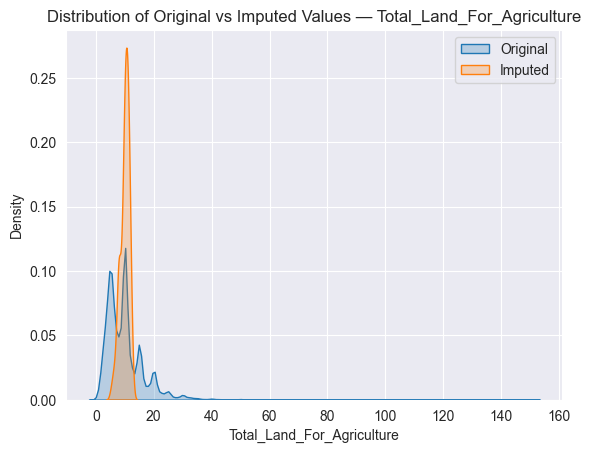

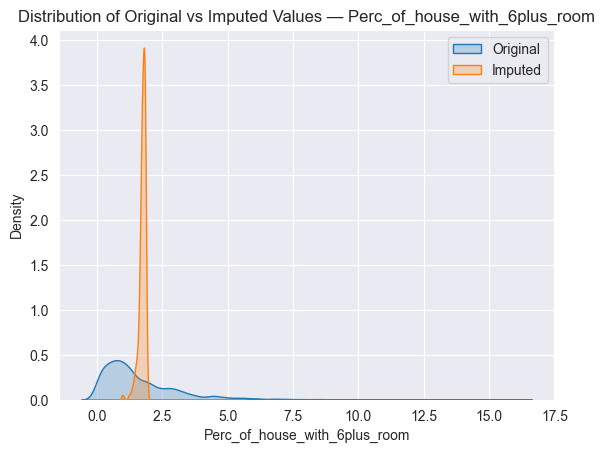

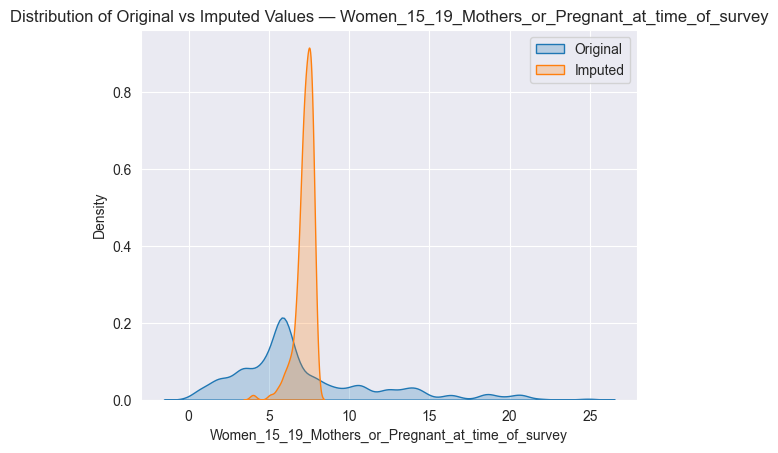

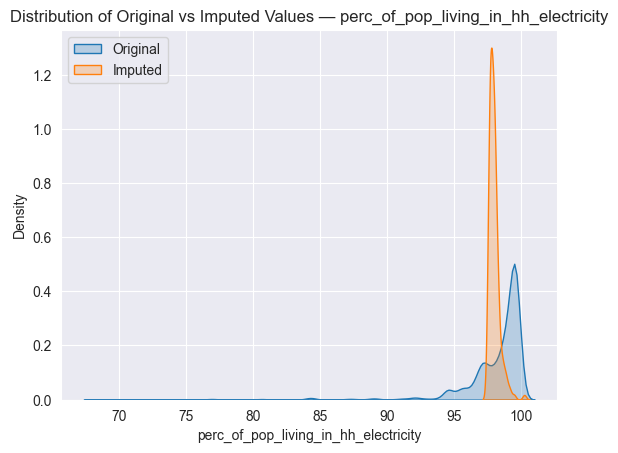

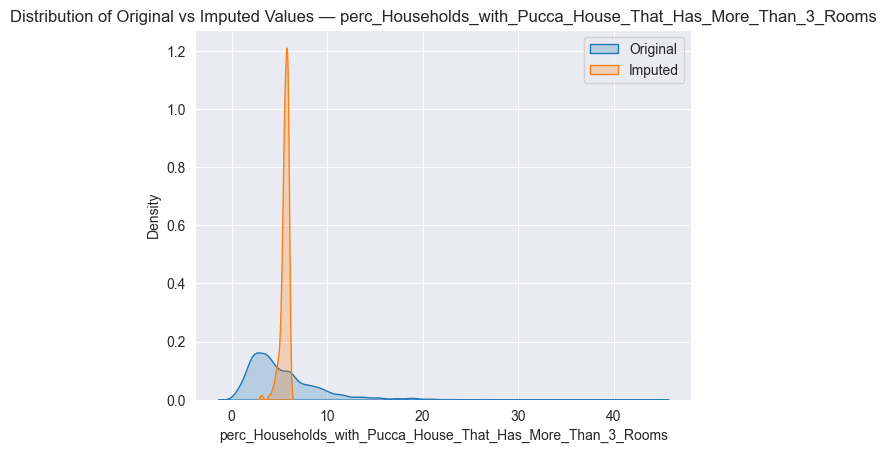

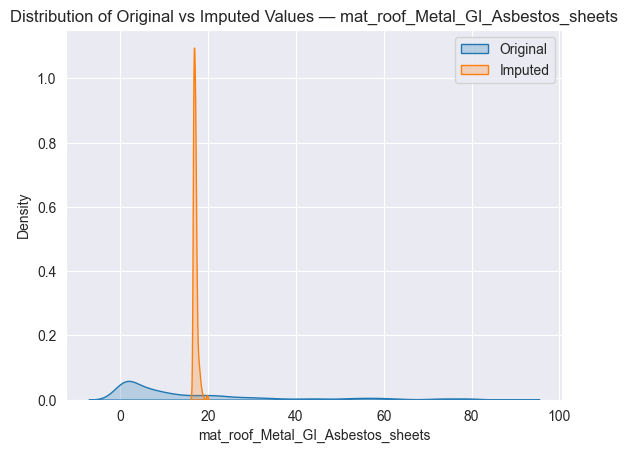

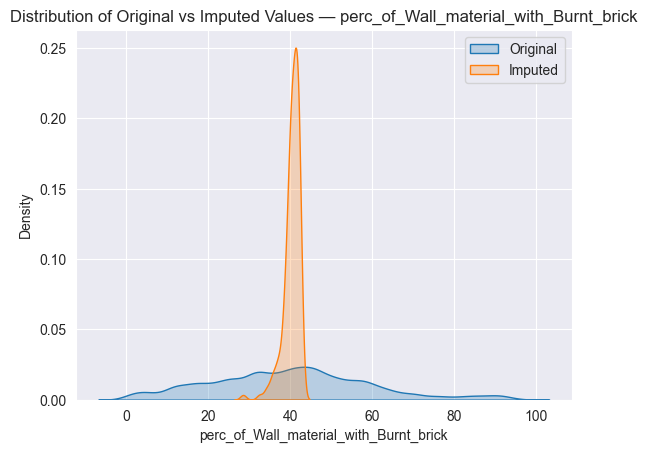

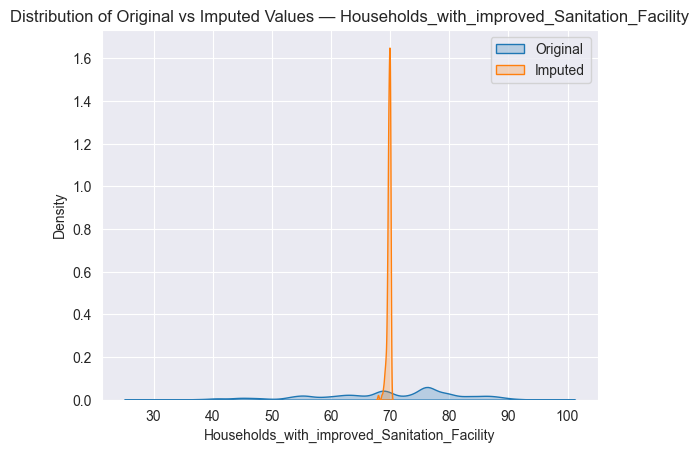

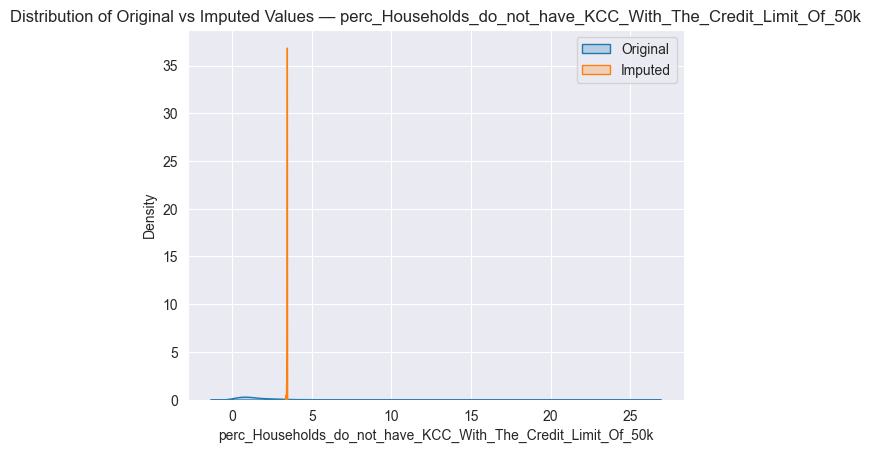

In [107]:
for col in missing_numeric:  # replace this

# Plot original (non-missing) values
    sns.kdeplot(original_data[col][~missing_masks[col]], label='Original', fill=True)

    # Plot imputed values
    sns.kdeplot(df_train[col][missing_masks[col]], label='Imputed', fill=True)

    plt.title(f'Distribution of Original vs Imputed Values — {col}')
    plt.legend()
    plt.show()

In [97]:
missing_data(missing_numeric)

Total_Land_For_Agriculture — Train: 0, Test: 0
Perc_of_house_with_6plus_room — Train: 0, Test: 0
Women_15_19_Mothers_or_Pregnant_at_time_of_survey — Train: 0, Test: 0
perc_of_pop_living_in_hh_electricity — Train: 0, Test: 0
perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms — Train: 0, Test: 0
mat_roof_Metal_GI_Asbestos_sheets — Train: 0, Test: 0
perc_of_Wall_material_with_Burnt_brick — Train: 0, Test: 0
Households_with_improved_Sanitation_Facility — Train: 0, Test: 0
perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k — Train: 0, Test: 0


In [108]:
missing_data()

Location — Train: 17030, Test: 3569
Address type — Train: 17030, Test: 3569
Ownership — Train: 17030, Test: 3569
Target_Variable/Total Income — Train: 0, Test: 9986


In [112]:
missing_non_numerical = ["Location", "Address type", "Ownership"]
print_unique_values(missing_non_numerical, k = 1)

Location: 30635
[nan '23.5131479,77.8207876' '22.7184042,78.2180971' ...
 '12.9956765,76.0817159' '13.2051248,76.168746' '13.3247225,76.2488811']
Address type: 4
[nan 'Permanent Address' 'Current Address' 'Both Addresses']
Ownership: 4
[nan 'Owned' 'Parental' 'Rented']


We use KNNimputer for Address type and Ownership

In [113]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Select columns
cat_cols = ["Address type", "Ownership"]

# Fit on train
df_train[cat_cols] = encoder.fit_transform(df_train[cat_cols])

# Transform test using same encoder
df_test[cat_cols] = encoder.transform(df_test[cat_cols])

In [114]:
from sklearn.impute import KNNImputer

In [115]:
knn_imputer = KNNImputer(n_neighbors=5)

df_train[cat_cols] = knn_imputer.fit_transform(df_train[cat_cols])
df_test[cat_cols] = knn_imputer.transform(df_test[cat_cols])

# Step 3: Optionally round imputed values to nearest integer (since categorical)
df_train[cat_cols] = df_train[cat_cols].round().astype(int)
df_test[cat_cols] = df_test[cat_cols].round().astype(int)

In [123]:
print_unique_values(cat_cols, k = 1)

Address type: 3
[2 1 0]
Ownership: 3
[0 1 2]


In [125]:
missing_data()
#just Location left

Location — Train: 17030, Test: 3569
Target_Variable/Total Income — Train: 0, Test: 9986


In [126]:
print_unique_values(non_numeric_columns)

State: 17
REGION: 5
SEX: 2
CITY: 2721
DISTRICT: 405
VILLAGE: 5650
MARITAL_STATUS: 3
Location: 30635
Address type: 3
Ownership: 3
K022-Village category based on Agri parameters (Good, Average, Poor): 2
K022-Nearest Mandi Name: 890
K022-Village category based on socio-economic parameters (Good, Average, Poor): 3
R022-Village category based on Agri parameters (Good, Average, Poor): 2
Kharif Seasons  Type of soil in 2022: 8
Kharif Seasons  Type of water bodies in hectares 2022: 22
Kharif Seasons  Agro Ecological Sub Zone in 2022: 12
Rabi Seasons Type of soil in 2022: 8
Rabi Seasons Type of water bodies in hectares 2022: 22
Rabi Seasons Agro Ecological Sub Zone in 2022: 12
Rabi Seasons Type of soil in 2021: 8
Rabi Seasons Type of water bodies in hectares 2021: 22
Rabi Seasons Agro Ecological Sub Zone in 2021: 12
Kharif Seasons Type of soil in 2021: 8
Kharif Seasons Type of water bodies in hectares 2021: 22
Kharif Seasons Agro Ecological Sub Zone in 2021: 12
Kharif Seasons Type of soil in 20

In [144]:
numeric_columns, non_numeric_columns = update_numeric()
for col in non_numeric_columns:
    print(col)

Total Columns: 111
Numeric Columns: 84
Non-Numeric Columns: 27
State
REGION
SEX
CITY
DISTRICT
VILLAGE
MARITAL_STATUS
Location
K022-Nearest Mandi Name
Kharif Seasons  Type of soil in 2022
Kharif Seasons  Type of water bodies in hectares 2022
Kharif Seasons  Agro Ecological Sub Zone in 2022
Rabi Seasons Type of soil in 2022
Rabi Seasons Type of water bodies in hectares 2022
Rabi Seasons Agro Ecological Sub Zone in 2022
Rabi Seasons Type of soil in 2021
Rabi Seasons Type of water bodies in hectares 2021
Rabi Seasons Agro Ecological Sub Zone in 2021
Kharif Seasons Type of soil in 2021
Kharif Seasons Type of water bodies in hectares 2021
Kharif Seasons Agro Ecological Sub Zone in 2021
Kharif Seasons Type of soil in 2020
Kharif Seasons Type of water bodies in hectares 2020
Kharif Seasons Agro Ecological Sub Zone in 2020
Rabi Seasons Type of soil in 2020
Rabi Seasons Type of water bodies in hectares 2020
Rabi Seasons Agro Ecological Sub Zone in 2020


In [145]:
print_unique_values(non_numeric_columns)

State: 17
REGION: 5
SEX: 2
CITY: 2721
DISTRICT: 405
VILLAGE: 5650
MARITAL_STATUS: 3
Location: 30635
K022-Nearest Mandi Name: 890
Kharif Seasons  Type of soil in 2022: 8
Kharif Seasons  Type of water bodies in hectares 2022: 22
Kharif Seasons  Agro Ecological Sub Zone in 2022: 12
Rabi Seasons Type of soil in 2022: 8
Rabi Seasons Type of water bodies in hectares 2022: 22
Rabi Seasons Agro Ecological Sub Zone in 2022: 12
Rabi Seasons Type of soil in 2021: 8
Rabi Seasons Type of water bodies in hectares 2021: 22
Rabi Seasons Agro Ecological Sub Zone in 2021: 12
Kharif Seasons Type of soil in 2021: 8
Kharif Seasons Type of water bodies in hectares 2021: 22
Kharif Seasons Agro Ecological Sub Zone in 2021: 12
Kharif Seasons Type of soil in 2020: 8
Kharif Seasons Type of water bodies in hectares 2020: 22
Kharif Seasons Agro Ecological Sub Zone in 2020: 12
Rabi Seasons Type of soil in 2020: 8
Rabi Seasons Type of water bodies in hectares 2020: 22
Rabi Seasons Agro Ecological Sub Zone in 2020: 1

In [151]:
#df_backup_train = df_train.copy()
#df_backup_test = df_test.copy()

In [147]:
to_remove = ["CITY", "VILLAGE", "Location"]
columns_to_encode = [col for col in non_numeric_columns if col not in to_remove]

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_train[columns_to_encode] = encoder.fit_transform(df_train[columns_to_encode])
df_test[columns_to_encode] = encoder.transform(df_test[columns_to_encode])

In [148]:
numeric_columns, non_numeric_columns = update_numeric()
for col in non_numeric_columns:
    print(col)

Total Columns: 111
Numeric Columns: 108
Non-Numeric Columns: 3
CITY
VILLAGE
Location


Now we use target encoding for village and city

In [150]:
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold

In [169]:
def target_encode_cv_smooth(train_df, test_df, column, target, n_splits=5, smoothing=10):
    """
    Cross-validated target encoding with smoothing.

    Parameters:
        train_df (pd.DataFrame): training data
        test_df (pd.DataFrame): test data
        column (str): column to encode
        target (str): target column name
        n_splits (int): number of folds
        smoothing (float): smoothing factor

    Returns:
        pd.Series: encoded training column
        pd.Series: encoded test column
    """
    # Initialize arrays
    encoded_train = pd.Series(index=train_df.index, dtype=float)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    global_mean = train_df[target].mean()

    for train_idx, val_idx in kf.split(train_df):
        train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]

        # Compute category means
        category_stats = train_fold.groupby(column)[target].agg(['mean', 'count'])
        # Compute smoothed mean
        smooth = (category_stats['mean'] * category_stats['count'] + global_mean * smoothing) / (category_stats['count'] + smoothing)

        # Map the smoothed means
        encoded_train.iloc[val_idx] = val_fold[column].map(smooth).fillna(global_mean)

    # Fit on full training set for test mapping
    full_stats = train_df.groupby(column)[target].agg(['mean', 'count'])
    smooth_full = (full_stats['mean'] * full_stats['count'] + global_mean * smoothing) / (full_stats['count'] + smoothing)

    encoded_test = test_df[column].map(smooth_full).fillna(global_mean)

    train_df[column + '_te'] = encoded_train
    test_df[column + '_te'] = encoded_test
    return train_df, test_df

In [178]:
df_train = df_backup_train
df_test = df_backup_test

In [179]:
numeric_columns, non_numeric_columns = update_numeric()

Total Columns: 113
Numeric Columns: 110
Non-Numeric Columns: 3


In [180]:
df_train, df_test = target_encode_cv_smooth(df_train, df_test, "VILLAGE", "Target_Variable/Total Income")
df_train, df_test= target_encode_cv_smooth(df_train, df_test, "CITY", "Target_Variable/Total Income")

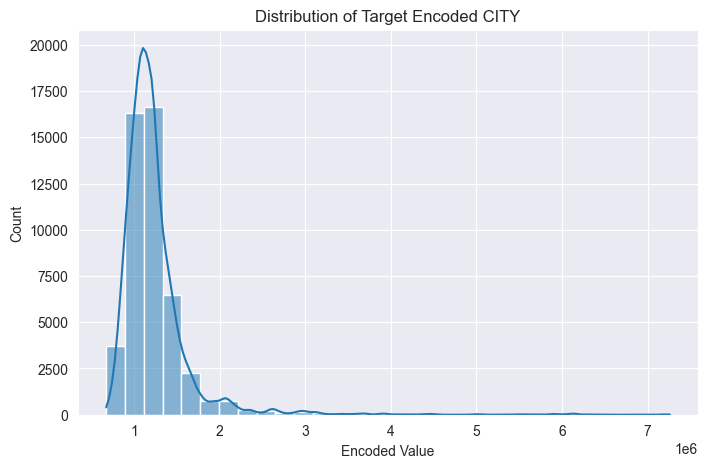

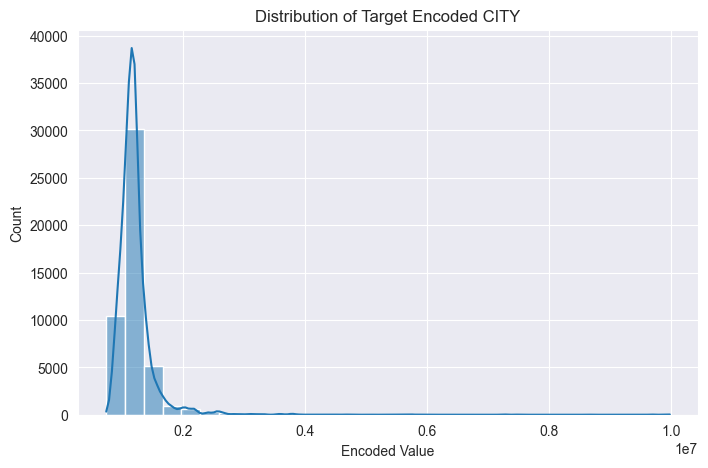

In [186]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["CITY_te"], bins=30, kde=True)
plt.title("Distribution of Target Encoded CITY")
plt.xlabel("Encoded Value")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_train["VILLAGE_te"], bins=30, kde=True)
plt.title("Distribution of Target Encoded CITY")
plt.xlabel("Encoded Value")
plt.ylabel("Count")
plt.show()

In [182]:
numeric_columns, non_numeric_columns = update_numeric()

Total Columns: 113
Numeric Columns: 110
Non-Numeric Columns: 3


In [183]:
print(non_numeric_columns)

['CITY', 'VILLAGE', 'Location']


In [184]:
missing_data()

Location — Train: 17030, Test: 3569
Target_Variable/Total Income — Train: 0, Test: 9986


In [185]:
df_train.to_excel("cleaned_train.xlsx", index=False)
df_test.to_excel("cleaned_test.xlsx", index=False)